# 37일차 -colab


## 빅데이터 활용 AI 설계
# DCGAN : MNIST

- GAN : Generative Adversarial Networks
- DCGAN : Deep Convolutional GAN
- Generator(생성자) / Discriminator(판별자)

<img src='https://wiki.pathmind.com/images/wiki/GANs.png' />
(출처 : https://wiki.pathmind.com/generative-adversarial-network-gan)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST 로딩

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
X_train = X_train/255
X_test = X_test/255

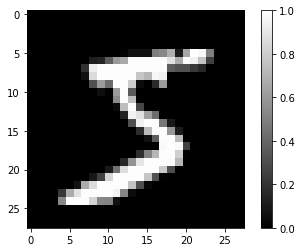

In [5]:
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()

In [6]:
X_train = X_train[:,:,:,np.newaxis] # X_train.reshape(-1,28,28,1)
X_test = X_test[:,:,:,np.newaxis]

In [7]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((60000, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [8]:
X_test.shape

(10000, 28, 28, 1)

### 판별자 정의

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop

In [10]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928

<img src='https://www.researchgate.net/profile/Sepp_Hochreiter/publication/284579051/figure/fig1/AS:614057178578955@1523414048184/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs.png' />
(출처: https://www.researchgate.net/figure/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs_fig1_284579051)

In [11]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### 생성자 정의

In [12]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512 

### 적대망 정의
- 생성자로 생성한 이미지가 판별자에 의해 '실제이미지' 로 판별되도록 생성자의 가중치를 조절한다

In [13]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         1301505   
_________________________________________________________________
model (Functional)           (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [14]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### 훈련하기
- fake images: 0, real images: 1
- 1 step 에 10초 정도 소요됨 (colab/cpu: 2초, colab/gpu: )
- C:\khh\프로그래밍\CNN\gan_images 폴더에 'fake_9.png' 형태로 저장함
- 생성자 모델을 'gan_mnist_generator_1000.h5' 로 저장함

In [16]:
! mkdir gan_images # !다음은 리눅스 명령어

mkdir: cannot create directory ‘gan_images’: File exists


In [17]:
! ls

gan_images  sample_data


In [18]:
from tensorflow.keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(10000):
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%100 == 0:
        #adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step+1)+'.png')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Step: 05001,  [0.5699912309646606, 0.65625, 1.7106006145477295, 0.046875]
Step: 05002,  [0.5101453065872192, 0.7578125, 1.1431993246078491, 0.28125]
Step: 05003,  [0.5288434624671936, 0.75, 1.4046547412872314, 0.140625]
Step: 05004,  [0.6024319529533386, 0.6796875, 0.9433594942092896, 0.34375]
Step: 05005,  [0.5664861798286438, 0.6796875, 1.522568702697754, 0.109375]
Step: 05006,  [0.55491042137146, 0.6953125, 0.8851508498191833, 0.359375]
Step: 05007,  [0.5452001094818115, 0.7578125, 1.6351755857467651, 0.109375]
Step: 05008,  [0.5859699249267578, 0.6875, 1.0170915126800537, 0.34375]
Step: 05009,  [0.4652146100997925, 0.7734375, 1.302966594696045, 0.15625]
Step: 05010,  [0.5274351835250854, 0.734375, 1.2296429872512817, 0.25]
Step: 05011,  [0.5410857200622559, 0.6953125, 1.5901167392730713, 0.078125]
Step: 05012,  [0.4846922755241394, 0.7578125, 1.2146803140640259, 0.265625]
Step: 05013,  [0.46735191345214844, 0.78125, 1.698400616645813, 0.125]
Step

n = 0


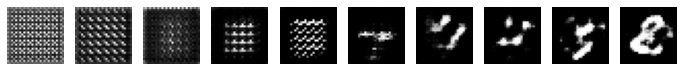

n = 1000


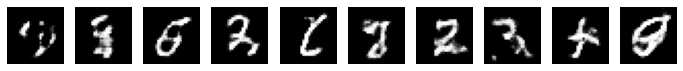

n = 2000


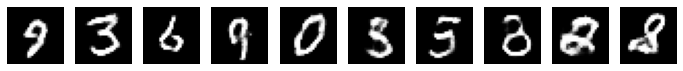

n = 3000


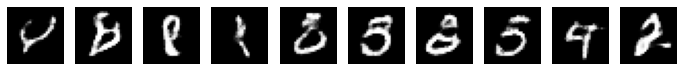

n = 4000


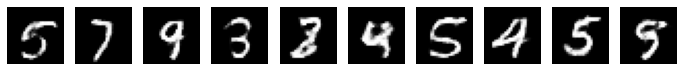

n = 5000


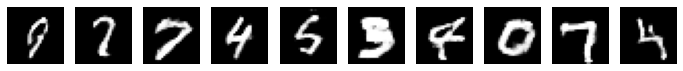

n = 6000


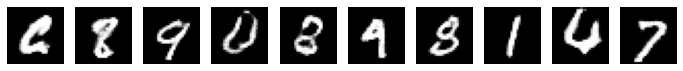

n = 7000


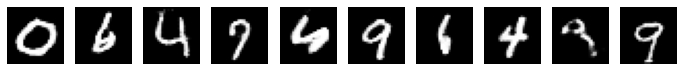

n = 8000


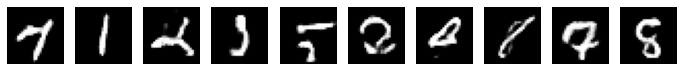

n = 9000


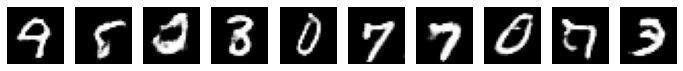

In [19]:
for n in range(0, 10000, 1000):
  print('n =',n)
  plt.figure(figsize=[12,10])
  
  for i in range(10):
    plt.subplot(1,10,i+1)
    img = plt.imread('gan_images/fake_'+str(n+100*(i+1))+'.png')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
   
  plt.show()

In [20]:
generator.save('gan_mnist_generator_10000.h5')

In [26]:
np.save('gan_mnist_log_10000.npy', logs)

In [27]:
! ls

gan_images  gan_mnist_generator_10000.h5  gan_mnist_log_10000.npy  sample_data


In [30]:
from google.colab import files

files.download('gan_mnist_log_10000.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 결과 분석

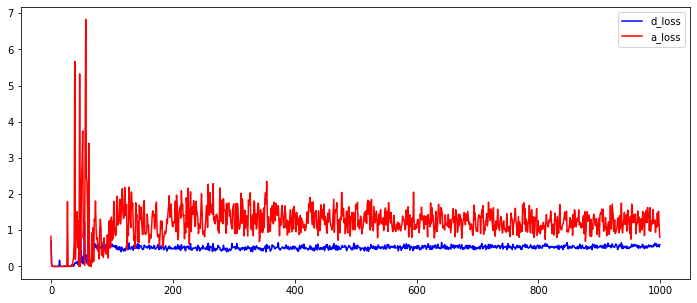

In [22]:
plt.figure(figsize=[12,5])

plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

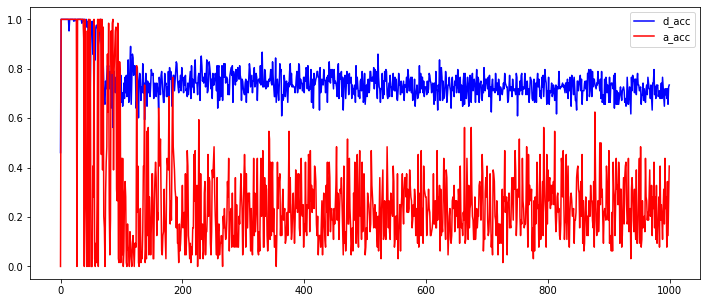

In [23]:
plt.figure(figsize=[12,5])

plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

- 결과 비교
<img src='https://d33wubrfki0l68.cloudfront.net/1439d140302850f4652f4def43d264b7afa39e65/81f84/assets/images/gan-intro/mnistkeras_19_0.png' />
(출처: https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/)

### 숫자 이미지 생성

In [24]:
from tensorflow.keras.models import load_model

#generator = load_model('gan_mnist_generator_1000.h5')

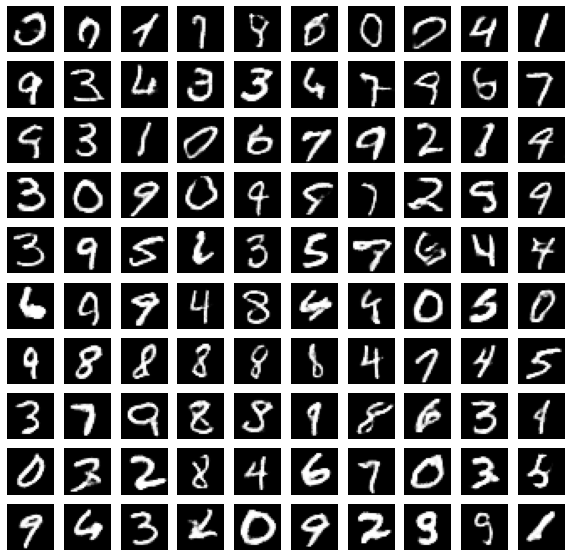

In [25]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')